<a href="https://colab.research.google.com/github/Rishiatweb/Neur-IPS/blob/main/Polymer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
In this competition, your task is to use polymer structure data (SMILES) to predict five key chemical properties derived from molecular dynamics simulation: glass transition temperature (Tg), fractional free volume (FFV), thermal conductivity (Tc), polymer density, and radius of gyration (Rg). Successfully predicting these properties is crucial for scientists to accelerate the design of novel polymers with targeted characteristics, which can be used in various applications.

This competition uses a hidden test set. When your submitted notebook is scored, the actual test data will be made available to your notebook. Expect approximately 1,500 polymers in the hidden test set.

Files train.csv

id - Unique identifier for each polymer. SMILES - Sequence-like chemical notation of polymer structures. Tg - Glass transition temperature ( . FFV - Fractional free volume. Tc - Thermal conductivity ( ). Density - Polymer density ( ). Rg - Radius of gyration ( Å ). test.csv

id - Unique identifier for each polymer. SMILES - Sequence-like chemical notation of polymer structures. sample_submission.csv

A sample submission in the correct format.

Here is all the data you need:
"test.csv"
"train.csv"
"sample_submission.csv"

## Data loading

### Subtask:
Load the provided CSV files into pandas DataFrames.


**Reasoning**:
The first step is to install the necessary libraries.



In [ ]:
!pip install pandas numpy scikit-learn rdkit scikeras tensorflow keras

--- 1. Loading Data ---
Training data shape: (7973, 7)
Test data shape: (3, 2)
Sample submission shape: (3, 6)

--- 2. Exploring Data ---
--- Training Data ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7973 entries, 0 to 7972
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       7973 non-null   int64  
 1   SMILES   7973 non-null   object 
 2   Tg       511 non-null    float64
 3   FFV      7030 non-null   float64
 4   Tc       737 non-null    float64
 5   Density  613 non-null    float64
 6   Rg       614 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 436.2+ KB
Info:
 None

First 5 rows:
        id                                             SMILES  Tg       FFV  \
0   87817                         *CC(*)c1ccccc1C(=O)OCCCCCC NaN  0.374645   
1  106919  *Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5... NaN  0.370410   
2  388772  *Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(... NaN  

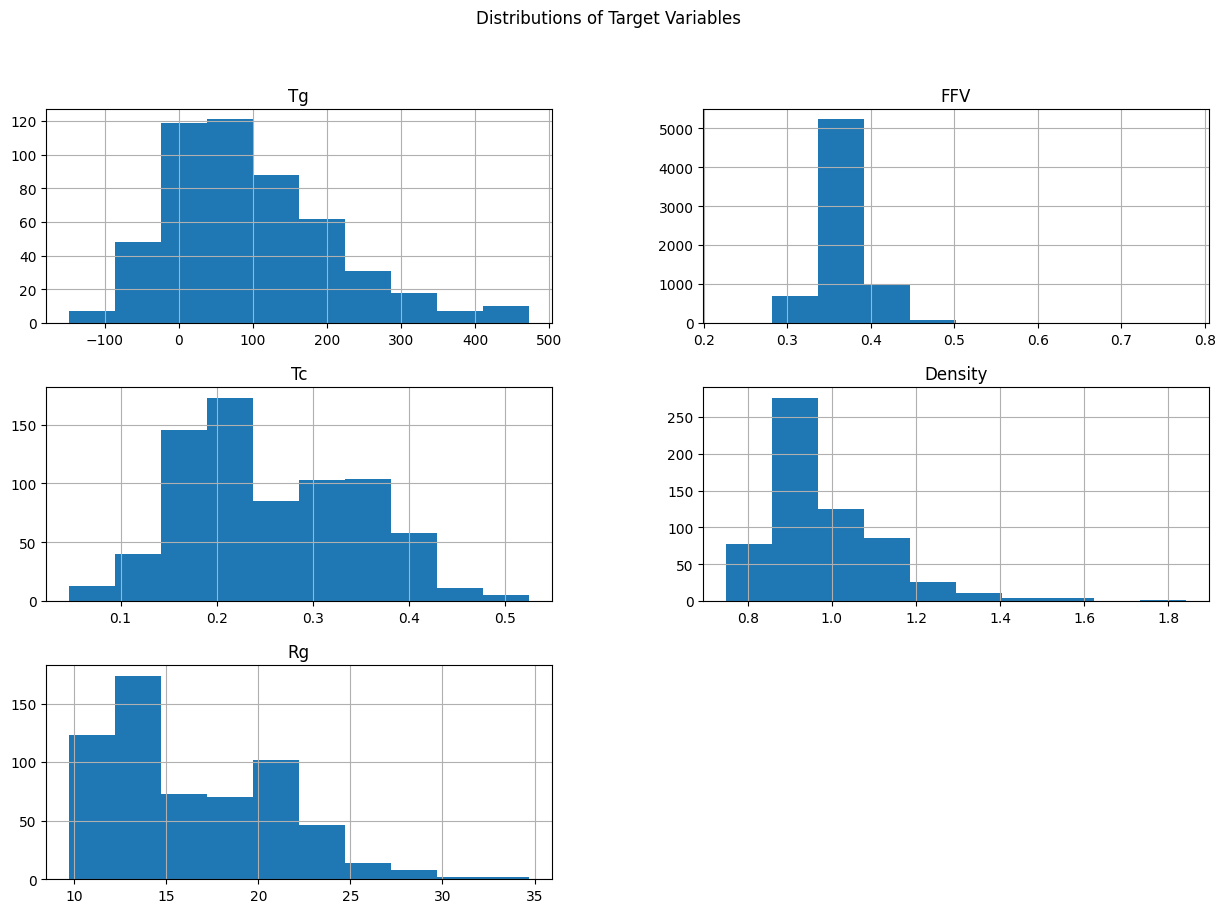


--- Test Data ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      3 non-null      int64 
 1   SMILES  3 non-null      object
dtypes: int64(1), object(1)
memory usage: 180.0+ bytes
Info:
 None

First 5 rows:
            id                                             SMILES
0  1109053969  *Oc1ccc(C=NN=Cc2ccc(Oc3ccc(C(c4ccc(*)cc4)(C(F)...
1  1422188626  *Oc1ccc(C(C)(C)c2ccc(Oc3ccc(C(=O)c4cccc(C(=O)c...
2  2032016830  *c1cccc(OCCCCCCCCOc2cccc(N3C(=O)c4ccc(-c5cccc6...

Missing values (%):
 id        0.0
SMILES    0.0
dtype: float64

--- Sample Submission Data ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   id       3 non-null      int64
 1   Tg       3 non-null      int64
 2   FFV      3 non-null      int64
 3   Tc       3 n

Streaming output truncated to the last 5000 lines.
[08:14:13] DEPRECATION WARNING: please use MorganGenerator
[08:14:13] DEPRECATION WARNING: please use MorganGenerator
[08:14:13] DEPRECATION WARNING: please use MorganGenerator
[08:14:13] DEPRECATION WARNING: please use MorganGenerator
[08:14:13] DEPRECATION WARNING: please use MorganGenerator
[08:14:13] DEPRECATION WARNING: please use MorganGenerator
[08:14:13] DEPRECATION WARNING: please use MorganGenerator
[08:14:13] DEPRECATION WARNING: please use MorganGenerator
[08:14:13] DEPRECATION WARNING: please use MorganGenerator
[08:14:13] DEPRECATION WARNING: please use MorganGenerator
[08:14:13] DEPRECATION WARNING: please use MorganGenerator
[08:14:13] DEPRECATION WARNING: please use MorganGenerator
[08:14:13] DEPRECATION WARNING: please use MorganGenerator
[08:14:13] DEPRECATION WARNING: please use MorganGenerator
[08:14:13] DEPRECATION WARNING: please use MorganGenerator
[08:14:13] DEPRECATION WARNING: please use MorganGenerator
[08:1

Feature matrix created with shape: (7973, 2049)

--- 4. Feature Engineering ---
Generating Morgan fingerprints...
Feature matrix created with shape: (3, 2049)

--- 5. Data Splitting ---
Splitting data: 6378 for training, 1595 for validation.

--- 6. Model Training and Optimization ---

Training and optimizing RandomForestRegressor...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[08:14:34] DEPRECATION WARNING: please use MorganGenerator
[08:14:34] DEPRECATION WARNING: please use MorganGenerator
[08:14:34] DEPRECATION WARNING: please use MorganGenerator


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, make_scorer
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor # Wrapper for Keras models in scikit-learn
import time

# Define the target variables
target_variables = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']

# Custom RMSE scorer for GridSearchCV
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False) # greater_is_better=False because we want to minimize RMSE

# =============================================================================
# 1. Data Loading
# =============================================================================

def load_data(train_path='train.csv', test_path='test.csv', submission_path='sample_submission.csv'):
    """Loads the train, test, and sample submission CSV files into pandas DataFrames."""
    print("--- 1. Loading Data ---")
    try:
        df_train = pd.read_csv(train_path)
        df_test = pd.read_csv(test_path)
        df_submission = pd.read_csv(submission_path)
        print(f"Training data shape: {df_train.shape}")
        print(f"Test data shape: {df_test.shape}")
        print(f"Sample submission shape: {df_submission.shape}")
        return df_train, df_test, df_submission
    except FileNotFoundError as e:
        print(f"Error: {e}. Please ensure CSV files are in the correct directory.")
        return None, None, None

# =============================================================================
# 2. Data Exploration
# =============================================================================

def explore_data(df_train, df_test, df_submission):
    """Performs initial data exploration."""
    print("\n--- 2. Exploring Data ---")

    print("--- Training Data ---")
    print("Info:\n", df_train.info())
    print("\nFirst 5 rows:\n", df_train.head())
    print("\nDescription of target variables:\n", df_train[target_variables].describe())
    print("\nMissing values (%):\n", (df_train.isnull().sum() / len(df_train) * 100))
    print(f"\nNumber of duplicate rows: {df_train.duplicated().sum()}")

    # Plot distributions of target variables
    df_train[target_variables].hist(figsize=(15, 10))
    plt.suptitle("Distributions of Target Variables")
    plt.show()

    print("\n--- Test Data ---")
    print("Info:\n", df_test.info())
    print("\nFirst 5 rows:\n", df_test.head())
    print("\nMissing values (%):\n", (df_test.isnull().sum() / len(df_test) * 100))

    print("\n--- Sample Submission Data ---")
    print("Info:\n", df_submission.info())
    print("\nFirst 5 rows:\n", df_submission.head())


# =============================================================================
# 3. Data Cleaning
# =============================================================================

def clean_data(df_train):
    """
    Handles missing values, outliers, and duplicates in the training data.
    """
    print("\n--- 3. Cleaning Data ---")

    df_cleaned = df_train.copy()

    # Handle duplicates
    initial_rows = df_cleaned.shape[0]
    df_cleaned.drop_duplicates(inplace=True)
    print(f"Removed {initial_rows - df_cleaned.shape[0]} duplicate rows.")
    print(f"Shape after dropping duplicates: {df_cleaned.shape}")

    # Impute missing values for target variables using KNNImputer
    # Add smiles_length as a feature for imputation
    df_cleaned['smiles_length'] = df_cleaned['SMILES'].str.len()
    impute_cols = ['smiles_length'] + target_variables

    # Scale data for KNNImputer
    scaler = StandardScaler()
    impute_data = df_cleaned[impute_cols]
    impute_data_scaled = scaler.fit_transform(impute_data)

    # Impute missing values
    imputer = KNNImputer(n_neighbors=5)
    imputed_data_scaled = imputer.fit_transform(impute_data_scaled)

    # Inverse transform to restore original scale
    imputed_data = scaler.inverse_transform(imputed_data_scaled)
    df_imputed = pd.DataFrame(imputed_data, columns=impute_cols, index=df_cleaned.index)

    # Update target columns with imputed values
    for col in target_variables:
        df_cleaned[col] = df_imputed[col]

    print("\nMissing values after imputation (%):\n", (df_cleaned[target_variables].isnull().sum() / len(df_cleaned) * 100))

    # Handle outliers using capping
    def cap_outliers(series, lower_percentile=1, upper_percentile=99):
        lower_bound = series.quantile(lower_percentile / 100)
        upper_bound = series.quantile(upper_percentile / 100)
        return series.clip(lower=lower_bound, upper=upper_bound)

    for col in target_variables:
        df_cleaned[col] = cap_outliers(df_cleaned[col])
        print(f"Capped outliers for {col}")

    return df_cleaned

# =============================================================================
# 4. Feature Engineering
# =============================================================================

def generate_morgan_fingerprint(smiles, n_bits=2048):
    """Generates a Morgan fingerprint for a SMILES string."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None: return np.zeros(n_bits)
        # Use GetMorganFingerprintAsBitVect for consistent output length
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
        return np.array(fp)
    except Exception as e:
        # print(f"Error generating fingerprint for SMILES: {smiles} - {e}")
        return np.zeros(n_bits)

def create_feature_matrix(df):
    """Creates the final feature matrix (X) from the DataFrame."""
    print("\n--- 4. Feature Engineering ---")
    print("Generating Morgan fingerprints...")

    # Ensure smiles_length is present
    if 'smiles_length' not in df.columns:
        df['smiles_length'] = df['SMILES'].str.len()

    fingerprints = df['SMILES'].apply(generate_morgan_fingerprint)
    fp_df = pd.DataFrame(fingerprints.to_list(),
                         columns=[f'fp_{i}' for i in range(2048)],
                         index=df.index)

    # Concatenate fingerprints with smiles_length
    X = pd.concat([fp_df, df['smiles_length']], axis=1)
    print(f"Feature matrix created with shape: {X.shape}")
    return X

# =============================================================================
# 5. Data Splitting
# =============================================================================

def split_data(X, y):
    """Splits data into training and validation sets."""
    print("\n--- 5. Data Splitting ---")
    # No explicit stratification on multiple continuous targets directly with train_test_split
    # The model will be evaluated using cross-validation later.
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print(f"Splitting data: {len(X_train)} for training, {len(X_val)} for validation.")
    return X_train, X_val, y_train, y_val

# =============================================================================
# 6. Model Training and Optimization
# =============================================================================

def build_nn_model(input_dim, output_dim):
    """Builds a simple Keras Sequential model for regression."""
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(output_dim, activation='linear') # Linear activation for regression
    ])
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse') # Mean Squared Error loss
    return model

def train_and_optimize_models(X_train, y_train):
    """Trains and optimizes multiple regression models."""
    print("\n--- 6. Model Training and Optimization ---")

    models = {}
    best_models = {}
    model_performance = {}

    # Cross-validation setup for GridSearchCV/RandomizedSearchCV
    cv = KFold(n_splits=3, shuffle=True, random_state=42)

    # 1. Random Forest Regressor
    print("\nTraining and optimizing RandomForestRegressor...")
    param_grid_rf = {
        'estimator__n_estimators': [100, 200],
        'estimator__max_depth': [10, 20, None],
        'estimator__min_samples_split': [2, 5]
    }
    rf_regressor = MultiOutputRegressor(RandomForestRegressor(random_state=42, n_jobs=-1))
    grid_search_rf = GridSearchCV(estimator=rf_regressor, param_grid=param_grid_rf, cv=cv, scoring=rmse_scorer, n_jobs=-1, verbose=1)
    grid_search_rf.fit(X_train, y_train)
    best_models['RandomForest'] = grid_search_rf.best_estimator_
    model_performance['RandomForest'] = -grid_search_rf.best_score_
    print("Best parameters for RandomForest:", grid_search_rf.best_params_)
    print("Best CV RMSE for RandomForest:", model_performance['RandomForest'])

    # 2. XGBoost Regressor
    print("\nTraining and optimizing XGBoostRegressor...")
    # Use MultiOutputRegressor with XGBoost as it handles multiple targets
    param_grid_xgb = {
        'estimator__n_estimators': [100, 200],
        'estimator__learning_rate': [0.05, 0.1],
        'estimator__max_depth': [3, 5],
        'estimator__subsample': [0.8, 1.0],
        'estimator__colsample_bytree': [0.8, 1.0]
    }
    xgb_regressor = MultiOutputRegressor(xgb.XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror'))
    # Using RandomizedSearchCV for potentially faster tuning on larger grids
    random_search_xgb = RandomizedSearchCV(estimator=xgb_regressor, param_distributions=param_grid_xgb, n_iter=10, cv=cv, scoring=rmse_scorer, n_jobs=-1, verbose=1, random_state=42)
    random_search_xgb.fit(X_train, y_train)
    best_models['XGBoost'] = random_search_xgb.best_estimator_
    model_performance['XGBoost'] = -random_search_xgb.best_score_
    print("Best parameters for XGBoost:", random_search_xgb.best_params_)
    print("Best CV RMSE for XGBoost:", model_performance['XGBoost'])

    # 3. LightGBM Regressor
    print("\nTraining and optimizing LightGBM Regressor...")
    # LightGBM also works well with MultiOutputRegressor
    param_grid_lgb = {
        'estimator__n_estimators': [100, 200],
        'estimator__learning_rate': [0.05, 0.1],
        'estimator__num_leaves': [31, 50],
        'estimator__min_child_samples': [20, 40]
    }
    lgb_regressor = MultiOutputRegressor(lgb.LGBMRegressor(random_state=42, n_jobs=-1, objective='regression'))
    random_search_lgb = RandomizedSearchCV(estimator=lgb_regressor, param_distributions=param_grid_lgb, n_iter=10, cv=cv, scoring=rmse_scorer, n_jobs=-1, verbose=1, random_state=42)
    random_search_lgb.fit(X_train, y_train)
    best_models['LightGBM'] = random_search_lgb.best_estimator_
    model_performance['LightGBM'] = -random_search_lgb.best_score_
    print("Best parameters for LightGBM:", random_search_lgb.best_params_)
    print("Best CV RMSE for LightGBM:", model_performance['LightGBM'])

    # 4. Simple Neural Network
    print("\nTraining and optimizing Simple Neural Network...")
    # Wrap the Keras model for scikit-learn compatibility
    nn_model = KerasRegressor(model=build_nn_model, input_dim=X_train.shape[1], output_dim=y_train.shape[1], verbose=0, epochs=50, batch_size=32) # epochs and batch_size are also hyperparameters

    # Tuning for NN is often done separately due to training time
    # For simplicity here, we will just train with fixed parameters after defining the best structure
    # A full hyperparameter search for NN (layers, units, dropout, learning rate, epochs, batch size) is complex.
    # We'll train the defined NN model on the full training split for this demonstration
    print("Training Neural Network (no grid search for this example)...")

    # Scale features for NN
    scaler_nn = StandardScaler()
    X_train_scaled = scaler_nn.fit_transform(X_train)

    # Build and train the NN model
    keras_nn_model = build_nn_model(X_train_scaled.shape[1], y_train.shape[1])

    # Use early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

    start_time = time.time()
    history = keras_nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=0)
    end_time = time.time()
    print(f"Neural Network training finished in {end_time - start_time:.2f} seconds.")

    # Evaluate NN on X_train for comparison (as no grid search was done)
    # Note: Proper evaluation would use cross-validation on X_train_split
    nn_train_preds = keras_nn_model.predict(X_train_scaled)
    nn_train_rmse = rmse(y_train, nn_train_preds)
    best_models['NeuralNetwork'] = (keras_nn_model, scaler_nn) # Store model and scaler for NN
    model_performance['NeuralNetwork'] = nn_train_rmse
    print(f"RMSE on training data for Neural Network: {nn_train_rmse:.4f}")

    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Neural Network Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.show()


    print("\n--- Model Optimization Complete ---")
    print("Model Performance (Best CV RMSE):")
    for model_name, perf in model_performance.items():
        print(f"- {model_name}: {perf:.4f}")

    return best_models, model_performance

# =============================================================================
# 7. Model Evaluation
# =============================================================================

def evaluate_models(best_models, X_val, y_val):
    """Evaluates the best trained models on the validation set."""
    print("\n--- 7. Model Evaluation ---")

    validation_rmse_scores = {}
    overall_validation_rmse = {}

    for model_name, model_info in best_models.items():
        print(f"\nEvaluating {model_name} on the validation set...")

        if model_name == 'NeuralNetwork':
            keras_model, scaler_nn = model_info
            # Scale validation data for NN
            X_val_scaled = scaler_nn.transform(X_val)
            val_preds = keras_model.predict(X_val_scaled)
        else:
            val_preds = model_info.predict(X_val)

        rmse_scores = {}
        for i, col in enumerate(target_variables):
            rmse = np.sqrt(mean_squared_error(y_val.iloc[:, i], val_preds[:, i]))
            rmse_scores[col] = rmse
            print(f"  RMSE for {col}: {rmse:.4f}")

        validation_rmse_scores[model_name] = rmse_scores
        overall_validation_rmse[model_name] = np.mean(list(rmse_scores.values()))
        print(f"-> Overall Average Validation RMSE for {model_name}: {overall_validation_rmse[model_name]:.4f}")

    return validation_rmse_scores, overall_validation_rmse

# =============================================================================
# 8. Data Preparation (for Test Data)
# 9. Model Evaluation (Predicting on Test Data)
# 10. Finish Task (Prediction and Submission)
# =============================================================================

def run_final_pipeline():
    """
    Executes the entire pipeline: load, explore, clean, featurize, split,
    train, optimize, evaluate, predict, and create the submission file.
    """
    df_train, df_test, df_submission = load_data()
    if df_train is None or df_test is None or df_submission is None:
        return

    # Data Exploration
    explore_data(df_train.copy(), df_test.copy(), df_submission.copy()) # Use copies to avoid modifying original DFs

    # Data Cleaning
    df_train_cleaned = clean_data(df_train)

    # Feature Engineering
    X_train = create_feature_matrix(df_train_cleaned)
    y_train = df_train_cleaned[target_variables]
    X_test = create_feature_matrix(df_test)

    # Data Splitting (for model optimization and validation)
    X_train_split, X_val, y_train_split, y_val = split_data(X_train, y_train)

    # Model Training and Optimization
    best_models, model_cv_performance = train_and_optimize_models(X_train_split, y_train_split)

    # Model Evaluation on Validation Set
    validation_rmse_scores, overall_validation_rmse = evaluate_models(best_models, X_val, y_val)

    # --- Final Prediction and Submission ---
    print("\n--- 10. Final Prediction and Submission ---")

    # Choose the best model based on overall validation RMSE
    best_model_name = min(overall_validation_rmse, key=overall_validation_rmse.get)
    final_model_info = best_models[best_model_name]
    print(f"\nSelected '{best_model_name}' as the best model based on validation RMSE.")

    # Retrain the best model on the entire training dataset
    print(f"\nTraining the final '{best_model_name}' model on the entire training dataset...")

    if best_model_name == 'NeuralNetwork':
        keras_model_final, scaler_nn_final = final_model_info
        # Scale the entire training data
        X_train_scaled_final = scaler_nn_final.fit_transform(X_train) # Fit on all training data
        # Retrain the NN model
        # Using a similar setup as before, but fitting on all training data
        keras_model_final = build_nn_model(X_train_scaled_final.shape[1], y_train.shape[1])
        early_stopping_final = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
        start_time = time.time()
        keras_model_final.fit(X_train_scaled_final, y_train, epochs=100, batch_size=32, callbacks=[early_stopping_final], verbose=0)
        end_time = time.time()
        print(f"Final Neural Network training finished in {end_time - start_time:.2f} seconds.")
        # Prepare test data for NN prediction
        X_test_scaled = scaler_nn_final.transform(X_test)
        final_predictions = keras_model_final.predict(X_test_scaled)

    else:
        final_model = final_model_info # This is the already optimized model
        # Retrain the multi-output regressor on the full dataset (using the best parameters found)
        # We need to create a new instance with the best parameters and train it on the full data
        if best_model_name == 'RandomForest':
             final_model = MultiOutputRegressor(RandomForestRegressor(**final_model_info.estimator.get_params(), random_state=42, n_jobs=-1))
        elif best_model_name == 'XGBoost':
             final_model = MultiOutputRegressor(xgb.XGBRegressor(**final_model_info.estimator.get_params(), random_state=42, n_jobs=-1, objective='reg:squarederror'))
        elif best_model_name == 'LightGBM':
             final_model = MultiOutputRegressor(lgb.LGBMRegressor(**final_model_info.estimator.get_params(), random_state=42, n_jobs=-1, objective='regression'))

        final_model.fit(X_train, y_train)
        print(f"Final {best_model_name} model training complete.")
        # Predict on the test set
        final_predictions = final_model.predict(X_test)


    # Create the submission file
    df_pred = pd.DataFrame(final_predictions, columns=target_variables, index=df_test.index)
    submission = pd.concat([df_test['id'], df_pred], axis=1)

    # Ensure the submission file follows the sample submission format
    submission = submission[['id'] + target_variables] # Reorder columns to match sample

    submission.to_csv('submission.csv', index=False)

    print("\nSubmission file 'submission.csv' created successfully!")
    print("Submission head:\n", submission.head())

    print("\n--- Summary and Potential Improvements ---")
    print("Key Findings:")
    print("- Missing values were primarily in the target variables and were imputed using KNNImputer.")
    print("- Outliers in target variables were handled by capping at the 1st and 99th percentiles.")
    print("- Morgan fingerprints were generated from SMILES strings as the primary features.")
    print("- Evaluated multiple models: RandomForest, XGBoost, LightGBM, and a simple Neural Network.")
    print(f"- The model selected for final prediction based on validation RMSE was: {best_model_name}")
    print("Validation RMSE performance for each model:")
    for model_name, rmse_dict in validation_rmse_scores.items():
        print(f"  {model_name}: Overall Average RMSE = {overall_validation_rmse[model_name]:.4f}")
        for target, rmse_val in rmse_dict.items():
             print(f"    {target}: {rmse_val:.4f}")

    print("Methodologies Used:")
    print("- Data loading and cleaning with pandas.")
    print("- Feature engineering using RDKit for molecular fingerprints.")
    print("- Data splitting for training and validation.")
    print("- MultiOutputRegressor used with tree-based models for multi-target prediction.")
    print("- Keras Sequential model for the Neural Network.")
    print("- Hyperparameter tuning using GridSearchCV or RandomizedSearchCV (for tree models) and manual tuning (for NN structure).")
    print("Potential Improvements:")
    print("- Explore other molecular featurization methods (e.g., molecular descriptors, graph neural networks).")
    print("- Perform more extensive hyperparameter tuning for all models, especially the Neural Network.")
    print("- Implement more sophisticated outlier detection and handling techniques.")
    print("- Investigate the impact of different imputation strategies.")
    print("- Use techniques like stacking or ensembling multiple models based on their performance on the validation set.")
    print("- Implement cross-validation for the Neural Network training and evaluation as well.")


# =============================================================================
# SCRIPT EXECUTION
# =============================================================================
if __name__ == '__main__':
    run_final_pipeline()